# DIRECT FEEDBACK ALIGNMENT

In this notebook a linear neural net with one hidden layer learns to multiply by a matrix using [direct feedback alignment](https://arxiv.org/pdf/1609.01596.pdf) instead of backpropagation.

In practice, it learns $ W_1 $, $W_2$ such that

$$ M = W_2 W_1 $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)

In [2]:
def create_dataset(n_in, n_out, len_samples):
    '''Creates randomly a matrix n_out x n_in which will be
       the target function to learn. Then generates
       len_samples examples which will be the training set'''
    M = np.random.randint(low=-10, high=10, size=(n_out, n_in))
    samples = []
    targets = []    
    for i in xrange(len_samples):
        sample = np.random.randn(n_in)
        samples.append(sample)
        targets.append(np.dot(M, sample))
        
    return M, np.asarray(samples), np.asarray(targets)

The forward pass is just

$$ \hat{y} = W_2 W_1 x$$

The backward pass for DFA takes the error $e = \hat{y}-y_{true}$ and projects it onto the dimension of the hidden layer:

$$\delta W_1 = -(B_1 e)x^T$$
$$\delta W_2 = -e a_1^T$$

where $a_1 = W_1 x$.

In [3]:
# Here lies all the logic of the network
def forward_pass(input, W1, W2):
    a1 = np.dot(W1, input)
    y_hat = np.dot(W2, a1)
    return a1, y_hat
    
def backward_pass(e, B1, input, a1):
    dW1 = -(np.dot(np.dot(B1, e), np.transpose(input)))
    dW2 = -np.dot(e, np.transpose(a1))
    
    return dW1, dW2

## WHAT ALIGNS WITH WHAT?

Theorem 1 in the paper states that the negative update directions $\delta h_i$ will try to maximize an alignment criterion which, in the case of two hidden layers, is:

$$L = L_k + L_{k+1} = \frac{\delta h_k^T c_k}{||\delta h_k||} + \frac{\delta h_{k+1}^T c_{k+1}}{||\delta h_{k+1}||}$$

where

$$c_k = \frac{\partial h_{k+1}}{\partial h_k}\delta h_{k+1} = W_{k+1}^T ( \delta h_{k+1} \odot f'(a_{k+1}))$$
$$c_{k+1} = \frac{\partial h_{k+1}}{\partial h_k^T}\delta h_k = (W_{k+1} \delta h_k) \odot f'(a_{k+1})$$

and $\delta h_{k+1} = e$ if $k+1$ is the output layer, $\delta h_k = B_k e$ for hidden layers.

$L_k >0$ implies that the angle between $\delta h_k$ and the backpropagated gradient $c_k$ is lower than $90°$:

$$\cos(\beta) = \frac{c_k^T \delta h_k}{||c_k||||\delta h_k||} = \frac{L_k}{||c_k||}>0 \rightarrow |\beta|<90°$$

Then $\delta h_k$ is pointing in a descending direction, because a vector within 90° of the steepest descending direction is also in a descending direction.

In [4]:
def average_angle(W2, B1, error):
    dh1 = np.dot(B1, error)
    c1 = np.dot(np.transpose(W2), error)
    
    # NUMPY USES SVD TO COMPUTE THE NORM-2 AS THE LARGEST 
    # SINGULAR VALUE OF THE MATRIX.
    # NORM-2 OF MATRICES NxM ARE PROPORTIONAL TO SQRT(NxM), THEREFORE
    # WE NEED TO NORMALIZE.
    dh1_norm = np.linalg.norm(dh1)/(np.sqrt(dh1.shape[0]*dh1.shape[1]))
    c1_norm = np.linalg.norm(c1)/(np.sqrt(c1.shape[0]*c1.shape[1]))
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)
    
    # ALIGNMENT CRITERION AND ANGLE
    Lk = np.mean(np.dot(np.transpose(dh1), c1)*inverse_dh1_norm*inverse_c1_norm)
    beta = np.arccos(np.clip(Lk, -1., 1.))*180/np.pi
    return Lk, beta

In [5]:
def train_on_dataset(samples, targets, n_in, n_out, n_hidden, n_epoch=4000):
    #learning rate
    lr = 1e-7
    #tolerance
    tol = 1e-4
    
    # Initialization of weights - they can be initialized to zero
    # (except when using ReLu activation functions) or randomly.
    W1 = np.zeros((n_hidden, n_in)) #np.random.randn(n_hidden, n_in)
    W2 = np.zeros((n_out, n_hidden)) #np.random.randn(n_out, n_hidden)
    
    # Initialization of the random feedback matrix - important
    # constraint: zero mean.
    B1 = np.random.randn(n_hidden, n_out)
    
    # initalize lists to save angles and alignment values during training
    angles = []
    Lk = []
    
    # transpose samples and targets to do batch training - in this case
    # we train the net on the whole dataset at once.
    samples = np.transpose(samples)
    targets = np.transpose(targets)
    
    # TRAINING
    for i in xrange(n_epoch):
        a1, y_hat = forward_pass(samples, W1, W2)
        errors = y_hat - targets
        cost = 0.5*np.sum((y_hat-targets)**2)
        dW1, dW2 = backward_pass(errors, B1, samples, a1)
        W1 += lr*dW1
        W2 += lr*dW2
        # every 50 epochs excpet for the first one (weights are zero
        # and norms go to zero -> numerical instability)
        if (i-1)%10==0:
            print 'Cost:', cost
            print 'Computing angle between updates - epoch', i
            crit, beta = average_angle(W2, B1, errors)
            angles.append(beta)
            Lk.append(crit)
            print 'Alignment criterion:', crit, '> 0', crit > 0, '\n'
        if cost <= tol:
            break
    return W1, W2, angles, Lk

In [6]:
# LET'S TRAIN!
M, samples, targets = create_dataset(10, 10, 1000)
w1, w2, angles, Lk = train_on_dataset(samples, targets, 10, 10, 1000) 

Cost: 1637494.94138
Computing angle between updates - epoch 1
Alignment criterion: 0.388724494595 > 0 True 

Cost: 1636395.35197
Computing angle between updates - epoch 11
Alignment criterion: 0.388803343567 > 0 True 

Cost: 1629503.60348
Computing angle between updates - epoch 21
Alignment criterion: 0.389294840975 > 0 True 

Cost: 1611581.20291
Computing angle between updates - epoch 31
Alignment criterion: 0.39058447337 > 0 True 

Cost: 1577976.59949
Computing angle between updates - epoch 41
Alignment criterion: 0.393059481926 > 0 True 

Cost: 1525205.7034
Computing angle between updates - epoch 51
Alignment criterion: 0.39710930142 > 0 True 

Cost: 1451576.65837
Computing angle between updates - epoch 61
Alignment criterion: 0.403124291053 > 0 True 

Cost: 1357655.54189
Computing angle between updates - epoch 71
Alignment criterion: 0.411490589193 > 0 True 

Cost: 1246367.808
Computing angle between updates - epoch 81
Alignment criterion: 0.422578038702 > 0 True 

Cost: 1122622.86

Let's define an error $$D = \sum_{i, j}|M_{ij}-O_{ij}|$$

In [7]:
O = np.dot(w2, w1)
print 'D:', np.sum(np.abs(M-O))

D: 0.0321989544435


(0, 100)

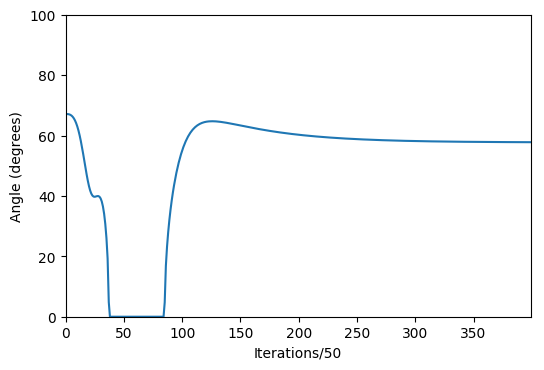

In [8]:
plt.plot(range(len(angles)), angles)
plt.xlabel('Iterations/50')
plt.ylabel('Angle (degrees)')
plt.xlim([0, range(len(angles))[-1]])
plt.ylim([0, 100])

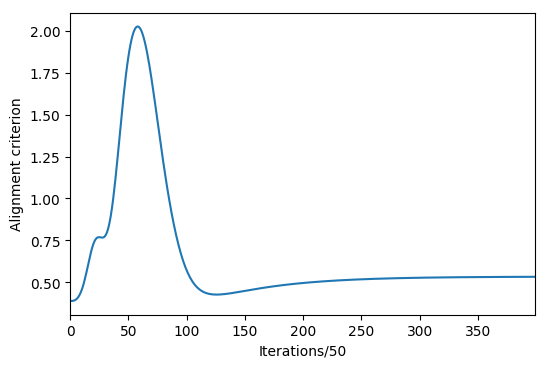

In [9]:
plt.plot(range(len(Lk)), Lk)
plt.xlim([0, range(len(Lk))[-1]])
plt.xlabel('Iterations/50')
plt.ylabel('Alignment criterion')

These plots are nonsense. The reason lies probably in the norm at the denominator, which as soon as the error decreases stops being proportional to the square root of the product of the dimensions.
We can try to see if the argument holds for *online training* (one sample at a time), where we won't have this normalization problem.

In [30]:
def angle(W2, B1, error):
    Be = np.dot(B1, error)
    dh1_norm = np.linalg.norm(Be)
    c1 = np.dot(np.transpose(W2), error)
    c1_norm = np.linalg.norm(c1)
    inverse_dh1_norm = np.power(dh1_norm, -1)
    inverse_c1_norm = np.power(c1_norm, -1)
    Lk = (np.dot(np.transpose(Be), c1)*inverse_dh1_norm*inverse_c1_norm)[0,0]
    return Lk, np.abs(np.arccos(np.clip(Lk, -1., 1.))*180/np.pi)

In [31]:
def online_train(samples, targets, n_in, n_out, n_hidden, n_epoch=1000):
    lr = 1e-6
    tol = 1e-5
    W1 = np.zeros((n_hidden, n_in)) #np.random.randn(n_hidden, n_in)
    W2 = np.zeros((n_out, n_hidden)) #np.random.randn(n_out, n_hidden)
    
    B1 = np.random.randn(n_hidden, n_out)
    angles = []
    Lk = []
    for i in xrange(n_epoch):
        # present examples one at a time
        for (sample, target) in zip(samples, targets):
            sample = np.expand_dims(sample, axis=1)
            target = np.expand_dims(target, axis=1)
            a1, a2 = forward_pass(sample, W1, W2)
            error = a2 - target
            cost = 0.5*np.sum((a2-target)**2)
            dW1, dW2 = backward_pass(error, B1, sample, a1)
            W1 += lr*dW1
            W2 += lr*dW2
        # comput the angle only sometimes to make the training faster
        if i%5==0 and i!=0:
            print 'Cost:', cost
            print 'Computing angle between updates - epoch', i
            crit, beta = angle(W2, B1, error)
            angles.append(beta)
            Lk.append(crit)
            print 'Criterion:', crit, '> 0', crit > 0, '\n'
        if cost <= tol:
            break
    return W1, W2, angles, Lk

In [32]:
M, samples, targets = create_dataset(10, 10, 1000)
w1, w2, angles, Lk = online_train(samples, targets, 10, 10, 1000) 

Cost: 2254.37896649
Computing angle between updates - epoch 5
Criterion: 0.93446419638 > 0 True 

Cost: 1227.82986488
Computing angle between updates - epoch 10
Criterion: 0.945299240633 > 0 True 

Cost: 444.102849873
Computing angle between updates - epoch 15
Criterion: 0.957820334013 > 0 True 

Cost: 133.588527755
Computing angle between updates - epoch 20
Criterion: 0.960400966104 > 0 True 

Cost: 38.7458255471
Computing angle between updates - epoch 25
Criterion: 0.948812669292 > 0 True 

Cost: 11.9487543105
Computing angle between updates - epoch 30
Criterion: 0.924483914905 > 0 True 

Cost: 4.19936932164
Computing angle between updates - epoch 35
Criterion: 0.895350994533 > 0 True 

Cost: 1.72753613692
Computing angle between updates - epoch 40
Criterion: 0.865667283129 > 0 True 

Cost: 0.82855471168
Computing angle between updates - epoch 45
Criterion: 0.827911995173 > 0 True 

Cost: 0.459446193883
Computing angle between updates - epoch 50
Criterion: 0.774235128841 > 0 True 

C

In [33]:
O = np.dot(w2, w1)
print 'D:', np.sum(np.abs(M-O))

D: 0.0496073854498


(0, 68)

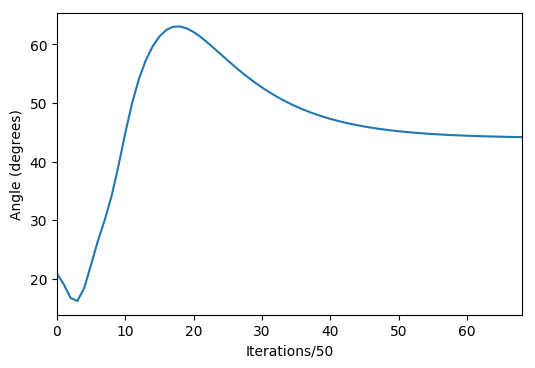

In [34]:
plt.plot(range(len(angles)), angles)
plt.xlabel('Iterations/50')
plt.ylabel('Angle (degrees)')
plt.xlim([0, range(len(angles))[-1]])

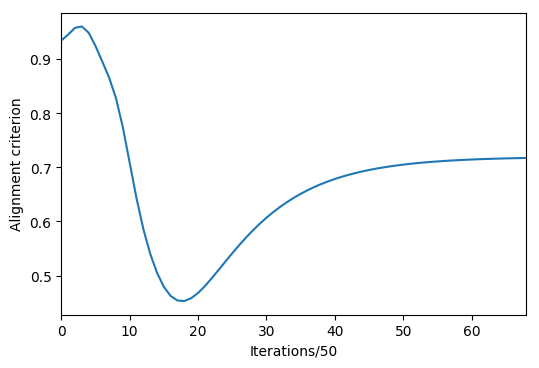

In [35]:
plt.plot(range(len(Lk)), Lk)
plt.xlim([0, range(len(Lk))[-1]])
plt.xlabel('Iterations/50')
plt.ylabel('Alignment criterion')